# **OptiRoute Pune**

### Phase 1 – Data Ingestion from OSM

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
place_name= "Pune, India"
graph= ox.graph_from_place(place_name, network_type='drive')        #Used network_type='drive' for drivable roads only

In [3]:
# Extract Nodes and Edges
nodes, edges= ox.graph_to_gdfs(graph)

In [4]:
ox.save_graphml(graph, filepath="data/pune_drive.graphml")
nodes.to_csv("data/pune_nodes.csv")
edges.to_csv("data/pune_edges.csv")

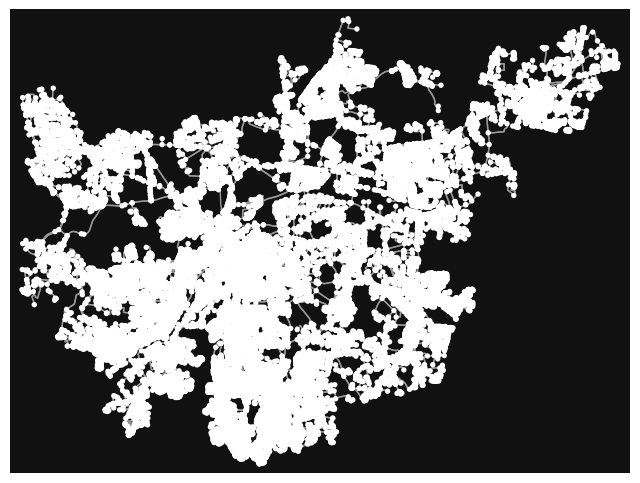

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [5]:
ox.plot_graph(graph)

### Phase 2 – Route Optimization (Graph Algorithms)

In [6]:
# viewing available edge attributes and enduring length is present
length_missing = False
count=0
max_print=10

for u, v, k , data in graph.edges(keys=True, data=True):
    if "length" not in data:
        length_missing= True
        break

    if count<max_print:
        print(data)
        count+=1

if length_missing:
    raise ValueError("Missing edge length")
else:
    print("All edges have the 'length' attribute")

{'osmid': 670151659, 'highway': 'residential', 'oneway': False, 'reversed': True, 'length': np.float64(10.313285220524842)}
{'osmid': 670151659, 'highway': 'residential', 'oneway': False, 'reversed': False, 'length': np.float64(34.254288743281144), 'geometry': <LINESTRING (73.895 18.442, 73.895 18.442, 73.895 18.442, 73.895 18.442)>}
{'osmid': 256448779, 'highway': 'trunk', 'lanes': '2', 'name': 'Katraj Kondhwa Road', 'oneway': True, 'reversed': False, 'length': np.float64(13.66454628690788)}
{'osmid': 888608969, 'highway': 'trunk', 'lanes': '2', 'name': 'Katraj Kondhwa Road', 'oneway': False, 'reversed': True, 'length': np.float64(51.983831698879584), 'geometry': <LINESTRING (73.859 18.447, 73.859 18.447, 73.859 18.447)>}
{'osmid': [858863081, 1022821427], 'highway': 'trunk', 'maxspeed': '50', 'name': 'Satara Road', 'oneway': True, 'ref': 'NH60', 'reversed': False, 'length': np.float64(115.52087683748464), 'geometry': <LINESTRING (73.859 18.447, 73.859 18.447, 73.859 18.447, 73.859 18

In [7]:
# finding the shortest route (Dijkstra) 
# X = longitude and Y=latitude, this is the reverse of typical (lat, lon) order used in many APIs

orig= ox.distance.nearest_nodes(graph, X=73.8567, Y=18.5204)
dest= ox.distance.nearest_nodes(graph, X=73.7800, Y=18.6500)

route= nx.shortest_path(graph, orig, dest, weight="length")

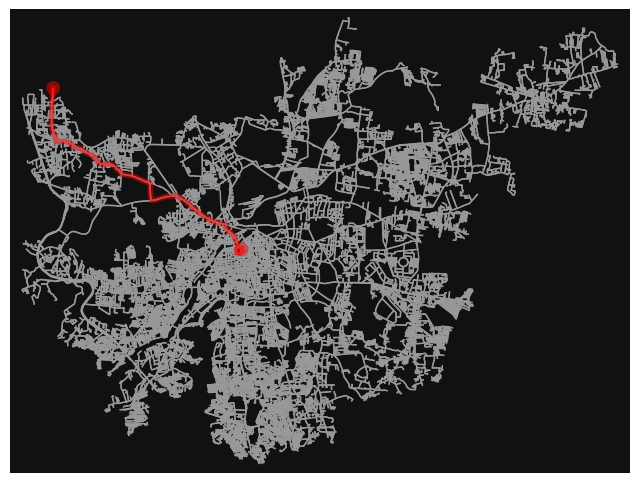

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# plotting the graph

ox.plot_graph_route(graph, route, route_linewidth=4, node_size=0)

In [9]:
# finding the shortest route A* implementation, it uses a heuristic function to guide its search towards the goal

route_a= nx.astar_path(graph, orig, dest, weight="length")

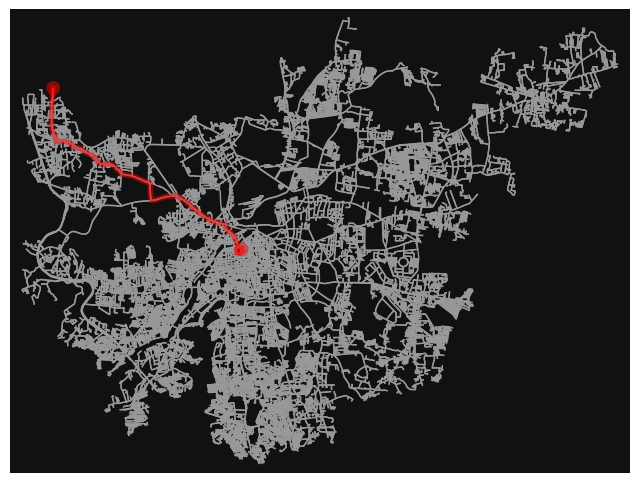

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [10]:
# plotting the graph

ox.plot_graph_route(graph, route_a, route_linewidth=4, node_size=0)

### Phase 3 – ML Component (Travel Time Estimation)

##### Goal- Estimate how long the route will take using a regression model trained on features like:
- Road type
- Segment length
- Time of day
- Speed limit or average speed

In [11]:
#Feature Engineering: Extracting features from each edge in the route

edge_data=[]
for u, v in zip(route[:-1], route[1:]):
    data= graph[u][v][0]    
    edge_data.append({
        "length": data.get("length", 0),
        "highway":data.get("highway", "unclassified"),
        "maxspeed": data.get("maxspeed", None)
    })

In [12]:
df= pd.DataFrame(edge_data)

In [13]:
df.head()

,length,highway,maxspeed
0,43.192759,residential,None
1,42.289896,trunk,None
2,55.550940,trunk,None
3,74.759017,trunk,None
4,178.161884,tertiary,None


In [14]:
# add time features manually
df["hour"]= 9       # ex- morning rush hour
df["day_of_week"]= 2       # Tuesday

In [15]:
df["highway"].unique()

array(['residential', 'trunk', 'tertiary', 'trunk_link', 'primary',
       'secondary'], dtype=object)

**Mapping of Highway Type → Assumed Average Speed (km/h)**
| Highway Type    | Max Speed (per article)                                              | Assumed Avg Speed | Reasoning                                                                                                    |
| --------------- | -------------------------------------------------------------------- | ----------------- | ------------------------------------------------------------------------------------------------------------ |
| **residential** | 30 km/h (typical residential areas; article says 30–40 for built-up) | **25**            | Narrow lanes, parked vehicles, pedestrians, speed breakers; average will be well below limit.                |
| **trunk**       | 100 km/h (national highways)                                         | **60**            | Highways have high limits but inside/near cities, traffic and junctions reduce real speed drastically.       |
| **tertiary**    | 50–60 km/h (minor roads, connecting local areas)                     | **35**            | Moderate traffic, mixed use, not as congested as residential but not free-flowing.                           |
| **trunk\_link** | 80–100 km/h (short connectors to highways)                           | **50**            | Short distance, but often bottlenecked by merging traffic.                                                   |
| **primary**     | 80 km/h (state highways)                                             | **45**            | Major city roads; congestion + signals keep avg much lower.                                                  |
| **secondary**   | 60–70 km/h (smaller connecting roads)                                | **40**            | Less capacity than primary, slightly better than tertiary in some rural stretches but slower in urban areas. |


In [17]:
# assuming avg speed per highway type
speed_map= {
    "residential": 25,
    "trunk": 60,
    "teriary": 35, 
    "trunk_link": 50,
    "primary": 45, 
    "secondary": 40
}

In [ ]:
df["speed_kmph"]= df["highway"].map(speed_map).fillna(30)
df["speed_mps"]= df["speed_kmph"]*(1000/3600)
df["travel_time_sec"]= df["length"]/df["speed_mps"]     # length is in meters

In [20]:
df.tail()

,length,highway,maxspeed,hour,day_of_week,speed_kmph,speed_mps,travel_time_sec
121,29.590934,tertiary,None,9,2,30.0,8.333333,3.550912
122,213.609682,tertiary,None,9,2,30.0,8.333333,25.633162
123,153.671415,residential,None,9,2,25.0,6.944444,22.128684
124,86.455415,residential,None,9,2,25.0,6.944444,12.449580
125,554.980709,residential,None,9,2,25.0,6.944444,79.917222
